# Cantidad total de vehiculos. 

La data contiene obs hasta 2018. Necesitamos hasta 2020 para comparar la cantidad de estaciones eléctricas y poder controlar por total de vehiculos. Por ello se van a pronosticar con un modelo 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv('Motor_Vehicle_Registrations.csv')

In [3]:
# Filtrando los datos para incluir solo los años desde 1980
data_since_1980 = data[data['year'] >= 1980]



In [4]:
data['year'].replace({2017: 1917}, inplace=True)

# Verificando nuevamente el rango de años después de la corrección
corrected_years_range = data['year'].unique()
corrected_years_range.sort()  # Ordenando los años para verificar la corrección

corrected_years_range

array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2018], dtype=int64)

In [5]:
# Función para predecir los valores de 2019 y 2020 para cada estado usando SARIMA
def predict_vehicle_type_sarima(data, vehicle_type):
    predictions = {}
    for state in data.index:
        state_data = data.loc[state].dropna()
        if len(state_data) > 2:  # Necesitamos al menos tres puntos para el modelo SARIMA
            # Diferenciación para lograr estacionariedad
            diff_state_data = state_data.diff().dropna()
            result_diff = adfuller(diff_state_data)
            if result_diff[1] < 0.05:  # Si la serie diferenciada es estacionaria
                model = sm.tsa.statespace.SARIMAX(state_data, 
                                                  order=(1, 1, 1), 
                                                  seasonal_order=(1, 1, 1, 12),
                                                  enforce_stationarity=False, 
                                                  enforce_invertibility=False)
                results = model.fit(disp=False)
                forecast = results.get_forecast(steps=2).predicted_mean
                predictions[state] = {2019: forecast.iloc[0], 2020: forecast.iloc[1]}
            else:
                predictions[state] = {2019: None, 2020: None}
        else:
            predictions[state] = {2019: None, 2020: None}
    return pd.DataFrame(predictions).T


In [6]:
# Creando DataFrames pivotados para cada tipo de vehículo
pivot_auto = data_since_1980.pivot_table(index='state', columns='year', values='Auto', aggfunc='sum')
pivot_bus = data_since_1980.pivot_table(index='state', columns='year', values='Bus', aggfunc='sum')
pivot_truck = data_since_1980.pivot_table(index='state', columns='year', values='Truck', aggfunc='sum')
pivot_motorcycle = data_since_1980.pivot_table(index='state', columns='year', values='Motorcycle', aggfunc='sum')


In [7]:
# Realizando las predicciones para cada tipo de vehículo usando SARIMA
predicted_auto_sarima = predict_vehicle_type_sarima(pivot_auto, 'Auto')
predicted_bus_sarima = predict_vehicle_type_sarima(pivot_bus, 'Bus')
predicted_truck_sarima = predict_vehicle_type_sarima(pivot_truck, 'Truck')
predicted_motorcycle_sarima = predict_vehicle_type_sarima(pivot_motorcycle, 'Motorcycle')


C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return g

In [8]:
# Uniendo las predicciones con los datos históricos para cada tipo de vehículo
final_auto_sarima = pivot_auto.join(predicted_auto_sarima, how='outer', rsuffix='_pred')
final_bus_sarima = pivot_bus.join(predicted_bus_sarima, how='outer', rsuffix='_pred')
final_truck_sarima = pivot_truck.join(predicted_truck_sarima, how='outer', rsuffix='_pred')
final_motorcycle_sarima = pivot_motorcycle.join(predicted_motorcycle_sarima, how='outer', rsuffix='_pred')


In [9]:
# Muestra de cómo se ven los DataFrames
final_auto_sarima.head()  # Muestra de cómo se ven los DataFrames para 'Auto'


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
state,,,,,,,,,,,,,,,,,,,,,
Alabama,2105546.0,2149718.0,2194794.0,2271950.0,2266571.0,2449566.0,2524671.0,2590443.0,2787788.0,2597723.0,...,2307668.0,2042489.0,2074969.0,2524145.0,2278262.0,2284443.0,2065463.0,2161212.0,2334917.18208,2319976.537092
Alaska,163193.0,178887.0,199956.0,218673.0,227375.0,186851.0,191368.0,187926.0,190070.0,191946.0,...,215688.0,193151.0,201042.0,195389.0,193348.0,183259.0,173487.0,183270.0,182493.445889,183635.037542
Arizona,1372742.0,1507320.0,1582896.0,1634258.0,1504204.0,1543782.0,1607942.0,1804908.0,1868428.0,1886862.0,...,2363015.0,2124041.0,2257249.0,2320664.0,2332734.0,2377962.0,2391624.0,2391772.0,2387673.749861,2423839.900479
Arkansas,1036456.0,1092943.0,959404.0,938180.0,860732.0,905351.0,937944.0,953887.0,929244.0,948690.0,...,1021817.0,881272.0,865210.0,989291.0,947789.0,942604.0,926789.0,921161.0,929061.155234,924466.041917
California,13268006.0,13208593.0,13420945.0,13935390.0,14095912.0,13968518.0,14415379.0,14629229.0,15224990.0,15338606.0,...,14549841.0,13223822.0,13822505.0,14065989.0,14463569.0,14768392.0,14860967.0,15065827.0,15207947.612793,16331676.241588


In [10]:
# Uniendo los DataFrames de predicciones con los datos históricos para cada tipo de vehículo
state_auto = final_auto_sarima.stack().reset_index().rename(columns={0: 'Auto'})
state_bus = final_bus_sarima.stack().reset_index().rename(columns={0: 'Bus'})
state_truck = final_truck_sarima.stack().reset_index().rename(columns={0: 'Truck'})
state_motorcycle = final_motorcycle_sarima.stack().reset_index().rename(columns={0: 'Motorcycle'})

# Combinando los DataFrames individuales en un único DataFrame con todas las categorías de vehículos y el total
combined_df = pd.merge(state_auto, state_bus, on=['state', 'level_1'], how='outer')
combined_df = pd.merge(combined_df, state_truck, on=['state', 'level_1'], how='outer')
combined_df = pd.merge(combined_df, state_motorcycle, on=['state', 'level_1'], how='outer')


In [11]:
# Renombrando la columna 'level_1' a 'year' y reordenando las columnas
combined_df.rename(columns={'level_1': 'year'}, inplace=True)
combined_df = combined_df[['year', 'state', 'Auto', 'Bus', 'Truck', 'Motorcycle']]

# Calculando el total de vehículos por año y estado
combined_df['Total_Vehicles'] = combined_df[['Auto', 'Bus', 'Truck', 'Motorcycle']].sum(axis=1)



In [12]:
combined_df.head()  # Mostrando los primeros registros del DataFrame combinado

,year,state,Auto,Bus,Truck,Motorcycle,Total_Vehicles
0,1980,Alabama,2105546.0,8716.0,823846.0,75990.0,3014098.0
1,1981,Alabama,2149718.0,8731.0,852841.0,73323.0,3084613.0
2,1982,Alabama,2194794.0,8300.0,836366.0,70895.0,3110355.0
3,1983,Alabama,2271950.0,8503.0,864316.0,72506.0,3217275.0
4,1984,Alabama,2266571.0,8375.0,927109.0,69637.0,3271692.0


In [13]:
state_abbreviations = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", 
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", 
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", 
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", 
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", 
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", 
    "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", 
    "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", 
    "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", 
    "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", 
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY", "Dist. of Col.": "DC", "District of Columbia": "DC"
}

# Aplicar el mapeo al DataFrame vehicles_total_df
combined_df['state'] = combined_df['state'].map(state_abbreviations)

# Verificar si la transformación fue exitosa
combined_df.head()


,year,state,Auto,Bus,Truck,Motorcycle,Total_Vehicles
0,1980,AL,2105546.0,8716.0,823846.0,75990.0,3014098.0
1,1981,AL,2149718.0,8731.0,852841.0,73323.0,3084613.0
2,1982,AL,2194794.0,8300.0,836366.0,70895.0,3110355.0
3,1983,AL,2271950.0,8503.0,864316.0,72506.0,3217275.0
4,1984,AL,2266571.0,8375.0,927109.0,69637.0,3271692.0


In [14]:
combined_df.to_csv('vehicles_total_state-to2020.csv', index=False)


In [15]:
combined_df

,year,state,Auto,Bus,Truck,Motorcycle,Total_Vehicles
0,1980,AL,2105546.0,8716.0,823846.0,75990.0,3014098.0
1,1981,AL,2149718.0,8731.0,852841.0,73323.0,3084613.0
2,1982,AL,2194794.0,8300.0,836366.0,70895.0,3110355.0
3,1983,AL,2271950.0,8503.0,864316.0,72506.0,3217275.0
4,1984,AL,2266571.0,8375.0,927109.0,69637.0,3271692.0
...,...,...,...,...,...,...,...
2086,2020,MS,NaN,7064.607043,1215434.576948,29844.866815,1252344.050805
2087,2019,PA,NaN,57636.886267,5862244.413853,NaN,5919881.30012
2088,2020,PA,NaN,61288.647513,6184688.132078,NaN,6245976.779592
2089,2019,VA,NaN,35390.224799,4107515.492126,198606.337075,4341512.054


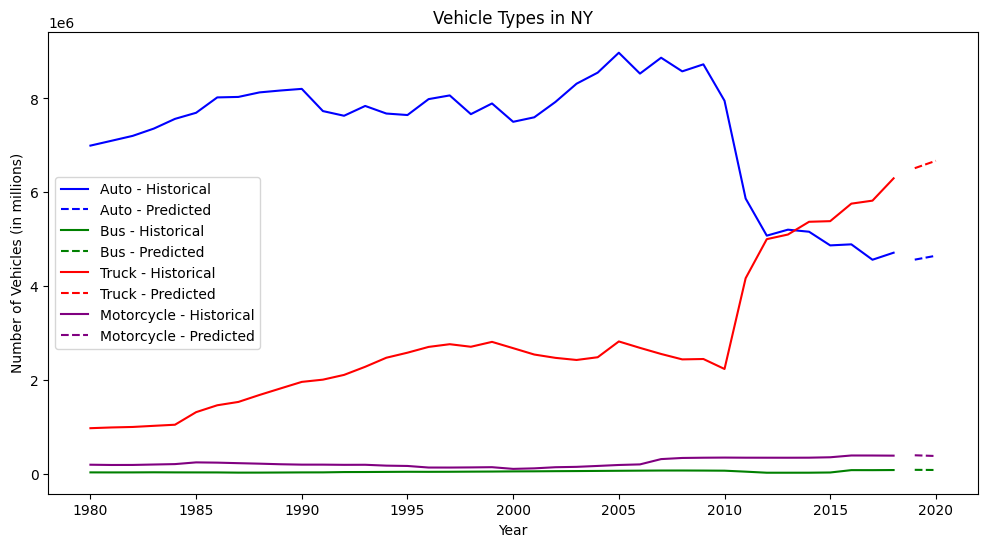

In [23]:
import matplotlib.pyplot as plt

# Función para graficar los datos históricos y las predicciones de todos los tipos de vehículos para un estado
def plot_all_vehicle_types(df, state):
    # Configurar colores para cada tipo de vehículo
    colors = {'Auto': 'blue', 'Bus': 'green', 'Truck': 'red', 'Motorcycle': 'purple'}

    plt.figure(figsize=(12, 6))

    for vehicle_type in colors.keys():
        # Filtrar los datos para el estado y tipo de vehículo específicos
        state_data = df[(df['state'] == state)]

        # Separar datos históricos de predicciones
        historical_data = state_data[state_data['year'] <= 2018]
        predicted_data = state_data[state_data['year'] > 2018]

        # Graficar datos históricos
        plt.plot(historical_data['year'], historical_data[vehicle_type], label=f'{vehicle_type} - Historical', color=colors[vehicle_type])

        # Graficar predicciones
        plt.plot(predicted_data['year'], predicted_data[vehicle_type], label=f'{vehicle_type} - Predicted', linestyle='--', color=colors[vehicle_type])

    plt.title(f'Vehicle Types in {state}')
    plt.xlabel('Year')
    plt.ylabel('Number of Vehicles (in millions)')
    plt.legend()
    plt.show()

# llamar a la función para Nueva York
plot_all_vehicle_types(combined_df, 'NY')

